In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

### Wie man Bikeshare-Daten direkt von AWS Bucket in ein DataFrame einlesen kann

In [2]:
import get_data as gd

In [3]:
# create urls for all the years required
urls = [
    gd.get_url(year)
    for year in gd.years
]

In [4]:
# generator with dataframe objects (lazy execution)
dfs = (
    gd.get_bike_data(url, is_folder=False)
    for url in urls
)

In [5]:
dfs

<generator object <genexpr> at 0x0000019CD3E147B0>

In [6]:
df_0 = next(dfs)

In [7]:
df_0.head()

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,1012,2010-09-20 11:27:04,2010-09-20 11:43:56,31208,M St & New Jersey Ave SE,31108,4th & M St SW,W00742,Member
1,61,2010-09-20 11:41:22,2010-09-20 11:42:23,31209,1st & N St SE,31209,1st & N St SE,W00032,Member
2,2690,2010-09-20 12:05:37,2010-09-20 12:50:27,31600,5th & K St NW,31100,19th St & Pennsylvania Ave NW,W00993,Member
3,1406,2010-09-20 12:06:05,2010-09-20 12:29:32,31600,5th & K St NW,31602,Park Rd & Holmead Pl NW,W00344,Member
4,1413,2010-09-20 12:10:43,2010-09-20 12:34:17,31100,19th St & Pennsylvania Ave NW,31201,15th & P St NW,W00883,Member


In [8]:
df_1 = next(dfs)
df_1.head()

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,3548,2011-01-01 00:01:29,2011-01-01 01:00:37,31620,5th & F St NW,31620,5th & F St NW,W00247,Member
1,346,2011-01-01 00:02:46,2011-01-01 00:08:32,31105,14th & Harvard St NW,31101,14th & V St NW,W00675,Casual
2,562,2011-01-01 00:06:13,2011-01-01 00:15:36,31400,Georgia & New Hampshire Ave NW,31104,Adams Mill & Columbia Rd NW,W00357,Member
3,434,2011-01-01 00:09:21,2011-01-01 00:16:36,31111,10th & U St NW,31503,Florida Ave & R St NW,W00970,Member
4,233,2011-01-01 00:28:26,2011-01-01 00:32:19,31104,Adams Mill & Columbia Rd NW,31106,Calvert & Biltmore St NW,W00346,Casual


In [9]:
df = pd.concat([df_0, df_1])

In [10]:
df.shape

(1342364, 9)

In [11]:
df['End station number'].nunique()

144

In [12]:
df_0['Start station'].nunique()

106

In [5]:
def get_total_stations(year_df: pd.DataFrame) -> int:
    start_stations = year_df['Start station'].nunique()
    end_stations = year_df['End station'].nunique()
    return max(start_stations, end_stations)

# station_agg[year] = get_total_stations(year_df)

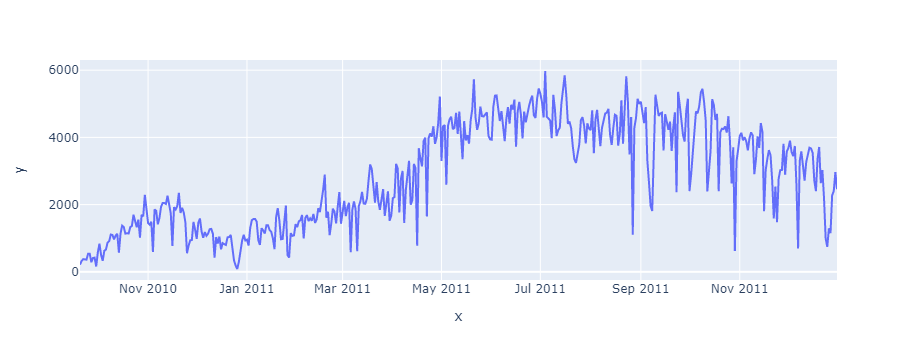

In [50]:
group = df.groupby(by=df['Start date'].dt.date)[['End station number']].count()
group.rename(columns={'End station number': 'rentals'}, inplace=True)
px.line(x=group.index, y=group.rentals)

In [6]:
def get_daily_rentals(year_df, all_years_df=None):
    if all_years_df is None:
        all_years_df = pd.DataFrame()
        
    group = year_df.groupby(by=year_df['Start date'].dt.date)[['End station number']].count()
    group.rename(columns={'End station number': 'rentals'}, inplace=True)
    
    return pd.concat([all_years_df, group])

In [ ]:
def most_busy_stations(year_df, all_years_df, grouby_col, count_col):
    
    group = year_df.groupby(by=grouby_col)[[count_col]].count()
    group.rename(columns={count_col: 'total_rentals'}, inplace=True)

In [7]:
station_counts = pd.DataFrame(columns=['total_stations'])
station_counts

,total_stations


In [24]:
df['Start date'].dt.year.unique()[0]

2010

### Aggregations on all data without reading in all of it at once

In [8]:
all_years = pd.DataFrame()
for _year_df in dfs:
    # _year_df = next(dfs)
    year = _year_df['Start date'].dt.year.unique()[0]
    station_counts.loc[str(year)] = get_total_stations(_year_df)
    all_years = get_daily_rentals(_year_df, all_years)
    

In [9]:
station_counts

,total_stations
2010,107
2011,144
2012,191
2013,305
2014,346
2015,357
2016,435
2017,487
2018,522


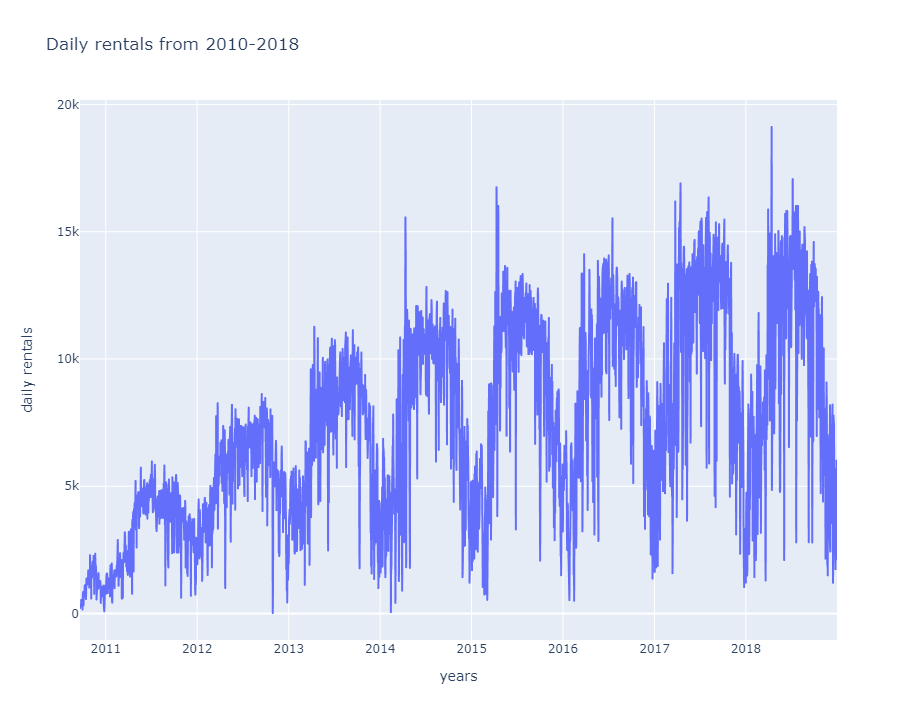

In [13]:
px.line(x=all_years.index, y=all_years.rentals, labels={'x': 'years', 'y': 'daily rentals'},
       title='Daily rentals from 2010-2018')

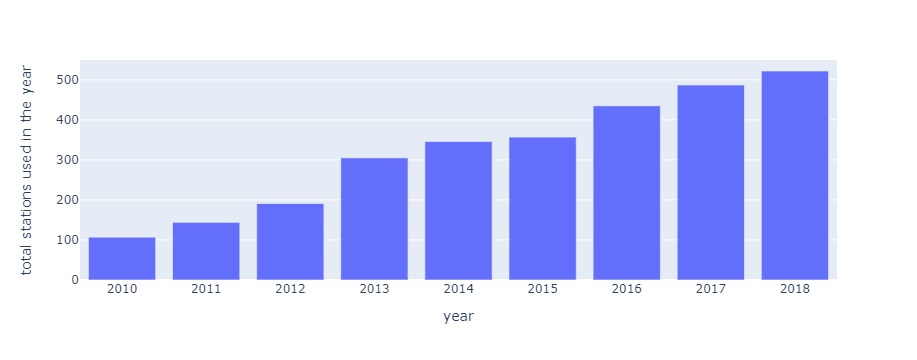

In [14]:
px.bar(x=station_counts.index, y=station_counts['total_stations'], labels={'x': 'year', 'y': 'total stations used in the year'})

<AxesSubplot:>

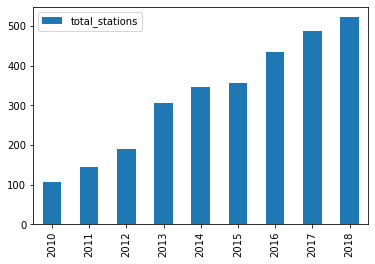

In [11]:
station_counts.plot(kind='bar')

In [16]:
urls

['https://s3.amazonaws.com/capitalbikeshare-data/2010-capitalbikeshare-tripdata.zip',
 'https://s3.amazonaws.com/capitalbikeshare-data/2011-capitalbikeshare-tripdata.zip',
 'https://s3.amazonaws.com/capitalbikeshare-data/2012-capitalbikeshare-tripdata.zip',
 'https://s3.amazonaws.com/capitalbikeshare-data/2013-capitalbikeshare-tripdata.zip',
 'https://s3.amazonaws.com/capitalbikeshare-data/2014-capitalbikeshare-tripdata.zip',
 'https://s3.amazonaws.com/capitalbikeshare-data/2015-capitalbikeshare-tripdata.zip',
 'https://s3.amazonaws.com/capitalbikeshare-data/2016-capitalbikeshare-tripdata.zip',
 'https://s3.amazonaws.com/capitalbikeshare-data/2017-capitalbikeshare-tripdata.zip',
 'https://s3.amazonaws.com/capitalbikeshare-data/201801-capitalbikeshare-tripdata.zip',
 'https://s3.amazonaws.com/capitalbikeshare-data/201802-capitalbikeshare-tripdata.zip',
 'https://s3.amazonaws.com/capitalbikeshare-data/201803-capitalbikeshare-tripdata.zip',
 'https://s3.amazonaws.com/capitalbikeshare-data

In [13]:
# df['Start station'] = df['Start station'].map(mapping_dictionary)
# df['End station'] = df['End station'].map(mapping_dictionary)

### combining the weather data for all the hours in the data

In [3]:
weather_df = pd.read_csv('Data/hourly_data.csv', skiprows=16)
weather_df.head()

,YEAR,MO,DY,HR,T2M,T2MDEW,QV2M,RH2M,PRECTOTCORR,WS10M,WD10M,PS
0,2009,12,31,19,0.01,-0.36,3.66,97.25,0.29,0.84,114.89,100.91
1,2009,12,31,20,0.09,-0.44,3.66,96.00,0.18,0.51,181.76,100.91
2,2009,12,31,21,-0.09,-0.54,3.60,96.69,0.12,1.06,185.92,100.87
3,2009,12,31,22,-0.17,-0.56,3.60,97.31,0.12,1.21,204.90,100.84
4,2009,12,31,23,-0.14,-0.51,3.66,97.38,0.08,1.19,218.89,100.77


In [4]:
weather_df.shape

(78888, 12)

In [5]:
weather_df.dtypes

YEAR             int64
MO               int64
DY               int64
HR               int64
T2M            float64
T2MDEW         float64
QV2M           float64
RH2M           float64
PRECTOTCORR    float64
WS10M          float64
WD10M          float64
PS             float64
dtype: object

In [4]:
weather_df['date'] = pd.to_datetime(
    weather_df['YEAR'].astype(str) + 
    weather_df['MO'].astype(str).str.zfill(2) + 
    weather_df['DY'].astype(str).str.zfill(2)
)

In [5]:
weather_df.head()

,YEAR,MO,DY,HR,T2M,T2MDEW,QV2M,RH2M,PRECTOTCORR,WS10M,WD10M,PS,date
0,2009,12,31,19,0.01,-0.36,3.66,97.25,0.29,0.84,114.89,100.91,2009-12-31
1,2009,12,31,20,0.09,-0.44,3.66,96.00,0.18,0.51,181.76,100.91,2009-12-31
2,2009,12,31,21,-0.09,-0.54,3.60,96.69,0.12,1.06,185.92,100.87,2009-12-31
3,2009,12,31,22,-0.17,-0.56,3.60,97.31,0.12,1.21,204.90,100.84,2009-12-31
4,2009,12,31,23,-0.14,-0.51,3.66,97.38,0.08,1.19,218.89,100.77,2009-12-31


In [9]:
capacity_df = pd.read_csv('Capital_Bike_Share_Locations.csv')
capacity_df.head(3)

,X,Y,OBJECTID,LATITUDE,LONGITUDE,NAME,STATION_TYPE,STATION_ID,STATION_STATUS,LAST_REPORTED,...,IOS,ANDROID,ELECTRIC_BIKE_SURCHARGE_WAIVER,EIGHTD_HAS_KEY_DISPENSER,CAPACITY,RENTAL_METHODS,REGION_ID,GIS_LAST_MOD_DTTM,GIS_ID,REGION_NAME
0,-77.004753,38.918166,30217974,38.918155,-77.004746,Rhode Island Ave & V St NE,classic,250,active,2022/04/16 04:32:41+00,...,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan,No,No,19,"KEY,CREDITCARD",42,2022/04/16 06:30:46+00,NaN,"Washington, DC"
1,-77.013915,38.892284,30217975,38.892275,-77.013917,Constitution Ave & 2nd St NW/DOL,classic,251,active,2022/04/15 23:26:46+00,...,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan,No,No,27,"KEY,CREDITCARD",42,2022/04/16 06:30:46+00,NaN,"Washington, DC"
2,-77.013776,38.886987,30217976,38.886978,-77.013769,Washington & Independence Ave SW/HHS,classic,252,active,2022/04/15 20:29:08+00,...,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan,No,No,31,"KEY,CREDITCARD",42,2022/04/16 06:30:46+00,NaN,"Washington, DC"


In [10]:
capacity_df = capacity_df[['NAME', 'CAPACITY']]

In [5]:
# main_df.merge(weather_df, on=['date', 'hour'])
bike_df = pd.read_parquet('Data/bike_data_10-19.parquet')

In [5]:
bike_df.head(3)

,ride_id,Bike_number,Duration,Start_date,End_date,Start_station,Start_station_number,Start_capacity,End_station,End_station_number,End_capacity,start_lat,start_lon,end_lat,end_lon,Member_type
0,0,W00742,1012,2010-09-20 11:27:04,2010-09-20 11:43:56,M St & New Jersey Ave SE,31208,17,4th & M St SW,31108,23,38.876304,-77.003702,38.876708,-77.017900,Member
1,1,W00032,61,2010-09-20 11:41:22,2010-09-20 11:42:23,1st & N St SE,31209,39,1st & N St SE,31209,39,38.874106,-77.005799,38.874106,-77.005799,Member
2,2,W00993,2690,2010-09-20 12:05:37,2010-09-20 12:50:27,5th & K St NW,31600,19,19th St & Pennsylvania Ave NW,31100,15,38.903048,-77.019025,38.900303,-77.042899,Member


In [6]:
bike_df['date'] = bike_df['Start_date'].dt.normalize()
bike_df['HR'] = bike_df['Start_date'].dt.hour

In [7]:
merged = bike_df.merge(weather_df, on=['date', 'HR'], how='left')

In [9]:
merged.columns

Index(['ride_id', 'Bike_number', 'Duration', 'Start_date', 'End_date',
       'Start_station', 'Start_station_number', 'Start_capacity',
       'End_station', 'End_station_number', 'End_capacity', 'start_lat',
       'start_lon', 'end_lat', 'end_lon', 'Member_type', 'date', 'HR', 'YEAR',
       'MO', 'DY', 'T2M', 'T2MDEW', 'QV2M', 'RH2M', 'PRECTOTCORR', 'WS10M',
       'WD10M', 'PS'],
      dtype='object')

In [8]:
merged.to_csv('bikehare_projekt.csv')

In [6]:
bike_df.memory_usage(deep=True)

Index                    209394728
ride_id                  209394728
Bike_number               53023655
Duration                 209394728
Start_date               209394728
End_date                 209394728
Start_station           2121463880
Start_station_number     209394728
Start_capacity           209394728
End_station             2117418602
End_station_number       209394728
End_capacity             209394728
start_lat                209394728
start_lon                209394728
end_lat                  209394728
end_lon                  209394728
Member_type               26174639
dtype: int64

In [7]:
cols = ['Bike_number', 'Duration', 'Start_station', 'Start_capacity', 'End_station', 'End_capacity']
bike_df = bike_df[cols]

In [8]:
bikes_table = pd.DataFrame({
    'Bike_number': bike_df.Bike_number.astype(str).unique(),
    'Duration': [0] * len(bike_df.Bike_number.astype(str).unique())
}
)

In [9]:
def update_capacity_dur_dist(row):
    """
    """
    row['time_rented'] = bikes_table.loc[bikes_table['Bike_number'] == row['Bike_number'], 'Duration'] + row['Duration']
    row['curr_start_capacity'] = capacity_df[capacity_df['NAME'] == row['Start_station']]['CAPACITY'] - 1
    row['curr_end_capacity'] = capacity_df[capacity_df['NAME'] == row['End_station']]['CAPACITY'] + 1
    
    capacity_df[capacity_df['NAME'] == row['Start_station']]['CAPACITY'] = capacity_df[
        capacity_df['NAME'] == row['Start_station']]['CAPACITY'] - 1
    capacity_df[capacity_df['NAME'] == row['End_station']]['CAPACITY'] = capacity_df[
        capacity_df['NAME'] == row['End_station']]['CAPACITY'] + 1
    
    bikes_table[bikes_table['Bike_number'] == row['Bike_number']]['Duration'] = bikes_table.loc[
        bikes_table['Bike_number'] == row['Bike_number'], 'Duration'] + row['Duration']
    
    return row

In [10]:
bike_df = bike_df.apply(update_capacity_dur_dist, axis=1)
bike_df.head(20)

KeyboardInterrupt: 

In [22]:
bike_df.groupby(by=bike_df.Bike_number.str[0]).count()

,ride_id,Bike_number,Duration,Start_date,End_date,Start_station,Start_station_number,Start_capacity,End_station,End_station_number,End_capacity,start_lat,start_lon,end_lat,end_lon,Member_type,date,HR
Bike_number,,,,,,,,,,,,,,,,,,
2,1951,1951,1951,1951,1951,1951,1951,1951,1951,1951,1951,1951,1951,1951,1951,1951,1951,1951
5,1771,1771,1771,1771,1771,1771,1771,1771,1771,1771,1771,1771,1771,1771,1771,1771,1771,1771
6,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563,4563
7,92887,92887,92887,92887,92887,92887,92887,92887,92887,92887,92887,92887,92887,92887,92887,92887,92887,92887
?,7436,7436,7436,7436,7436,7436,7436,7436,7436,7436,7436,7436,7436,7436,7436,7436,7436,7436
E,34160,34160,34160,34160,34160,34160,34160,34160,34160,34160,34160,34160,34160,34160,34160,34160,34160,34160
W,25970214,25970214,25970214,25970214,25970214,25970214,25970214,25970214,25970214,25970214,25970214,25970214,25970214,25970214,25970214,25970214,25970214,25970214
Z,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19
w,61326,61326,61326,61326,61326,61326,61326,61326,61326,61326,61326,61326,61326,61326,61326,61326,61326,61326
